# NLP Project Sentiment Analysis with BERT

## Setup

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install tensorflow --quiet 

     |████████████████████████████████| 3.4 MB 4.4 MB/s 
     |████████████████████████████████| 596 kB 32.8 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
     |████████████████████████████████| 61 kB 283 kB/s 
     |████████████████████████████████| 3.3 MB 36.7 MB/s 
     |████████████████████████████████| 306 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
     |████████████████████████████████| 243 kB 47.7 MB/s 
     |████████████████████████████████| 132 kB 51.7 MB/s 
     |████████████████████████████████| 192 kB 51.2 MB/s 
     |████████████████████████████████| 160 kB 53.9 MB/s 
     |████████████████████████████████| 271 kB 46.2 MB/s 


In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
import os
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

In [ ]:
#Connect to google drive JULE SPECIFIC
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/NLP/Project/data/')

Mounted at /content/drive/


In [ ]:
# To use the data I import it as a pandas data frame
tweets_df = pd.read_csv('AAPL_pddf.csv')

## Explore the data

###Plots and Data

In [ ]:
tweets_df.head(3)

,id,created_at,username,name,user_id,body,basic_sentiment,symbol0,symbol1,symbol2,symbol3,symbol4
0,410821194,2021-11-28 12:28:21+00:00,chuckygorman,Chuck Gorman,1068147,$AAPL $BA $DIS,0,AAPL,BA,DIS,NaN,NaN
1,410821004,2021-11-28 12:25:13+00:00,Renohawk,jessie livermore,162218,$SPY $TSLA $MRNA $AAPL $NVDA \n\nMy thoughts o...,0,AAPL,MRNA,NVDA,SPY,TSLA
2,410820720,2021-11-28 12:19:36+00:00,newtwo99,PS not a bot!,813188,$AAPL $BA $DIS $UNH,0,AAPL,BA,DIS,UNH,NaN


In [ ]:
tweets_df.columns


Index(['id', 'created_at', 'username', 'name', 'user_id', 'body',
       'basic_sentiment', 'symbol0', 'symbol1', 'symbol2', 'symbol3',
       'symbol4'],
      dtype='object')

In [ ]:
#Look at tweets
print(tweets_df['body'][3])

The industry average Profit Margin is 4.39%. $AAPL outperforms 93% of its industry peers. https://www.chartmill.com/stock/quote/AAPL/fundamental-analysis?key=bb853040-a4ac-41c6-b549-d218d2f21b32&amp;utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=AAPL&amp;utm_campaign=social_tracking


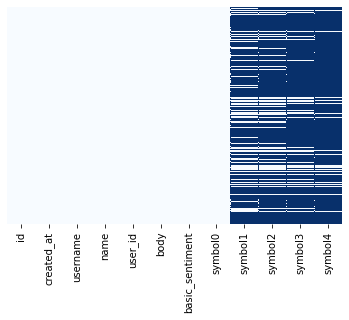

In [ ]:
#check if there are any null elements: if there are white lines in the box there are null elements
import seaborn as sns
sns.heatmap(tweets_df.isnull(),yticklabels=False, cbar=False, cmap='Blues')
#results show: there are only white lines in features symbol1-symbol4 which we dont need anyways

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


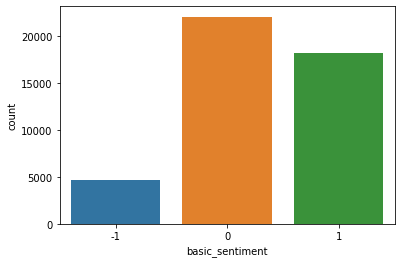

In [ ]:
# Make a histogramm of the labels
sns.countplot(tweets_df['basic_sentiment'],label='Count')
#label imbalance
#stratified train test split (Verteilung beider labels sollte in splitted datasets das gleiche Verhältnis haben) sklearn function hat das
#when training the model there is a parameter "importance/weights" (tensor flow bei model.fit classweight oder sample_weigth)
#Bei evaluierung nicht accuracy wählen!  confusion matrix  anschauen (F1 score, F beta score, precision recall)

In [ ]:
#Length of the tweets
#generate an additional column that contains the length of the tweets
tweets_df['length']=tweets_df['body'].apply(len)
tweets_df['length'].describe()

count    45000.000000
mean       106.986178
std        124.168693
min          5.000000
25%         35.000000
50%         69.000000
75%        133.000000
max       1599.000000
Name: length, dtype: float64

In [ ]:
#shortest tweet
print(tweets_df[tweets_df['length']==5]['body'].iloc[0])
#longest tweet
print(tweets_df[tweets_df['length']==1599]['body'].iloc[0])

$AAPL
$MAT This round of NFT&#39;s for Hotwheels, the cost will be only $15 dollars... TONS wll be sold, it&#39;s not like last time where there was a biddin war for ONLY three unique Hotwheels, back in June. These will price for only 15 dollars. Tons are gonna be sold. And they each come with a REAL DIECAST VERSION. 
 NEW ARTICLE : Mattel Partners with WAX 
$WAX.X
 to Release Hot Wheels NFT Garage - Series 1 Out November 16th, in time for the Holidays. 
Official Website NFT/WAX HOTWHEEL SITE / Starts Nov 16th : (WITH WEBSITE COUNTDOWN CLOCK....)
https://wdny.io/hotwheels-s1/
https://www.businesswire.com/news/home/20211026006314/en/Mattel-Partners-with-WAX-to-Release-Hot-Wheels-NFT-Garage---Series-1/

Plus ONU Partnership Anounced TODAY with 
Mattel, Inc. (NASDAQ: MAT) is dropping the first-ever collaboration between UNO&amp;Nike, featuring a product line developed in coordination with the 2019-20 Kia NBA Most Valuable Player and UNO fan, Giannis Antetokounmpo. This press release featu

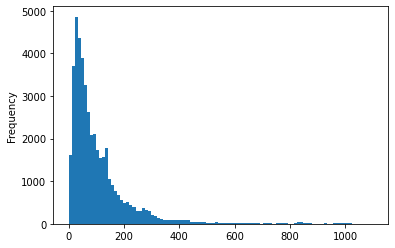

In [ ]:
#histogramm of tweet length
tweets_df['length'].plot(bins=100,kind='hist',range = [0,1100])

###Create a WordCloud

In [ ]:
#Postitive labels
positive = tweets_df[tweets_df['basic_sentiment']==-1]
negative = tweets_df[tweets_df['basic_sentiment']== 1]

#Turn all tweets into one string 
sentences = tweets_df['body'].tolist() #turns the tweet column into a list
len(sentences) # list has same length as number of tweets
sentences_as_one_string = "".join(sentences) # turns all sequences into one string

sentences_positive = positive['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_positive = "".join(sentences_positive) # turns all sequences into one string

sentences_negative = negative['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_negative = "".join(sentences_negative) # turns all sequences into one string


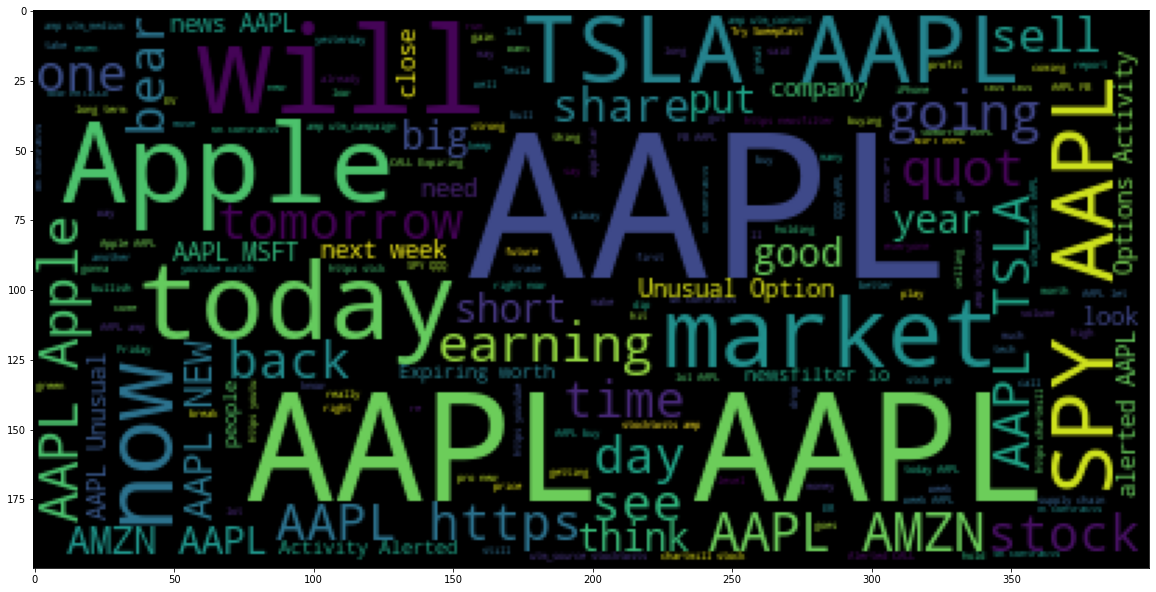

In [ ]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

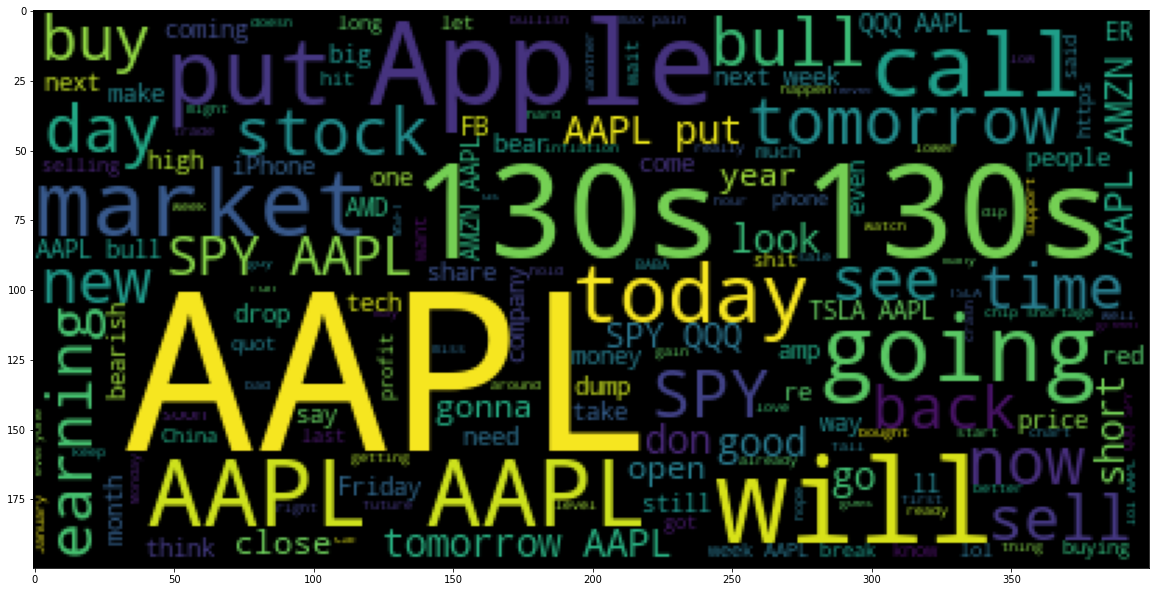

In [ ]:
#postive WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_positive))

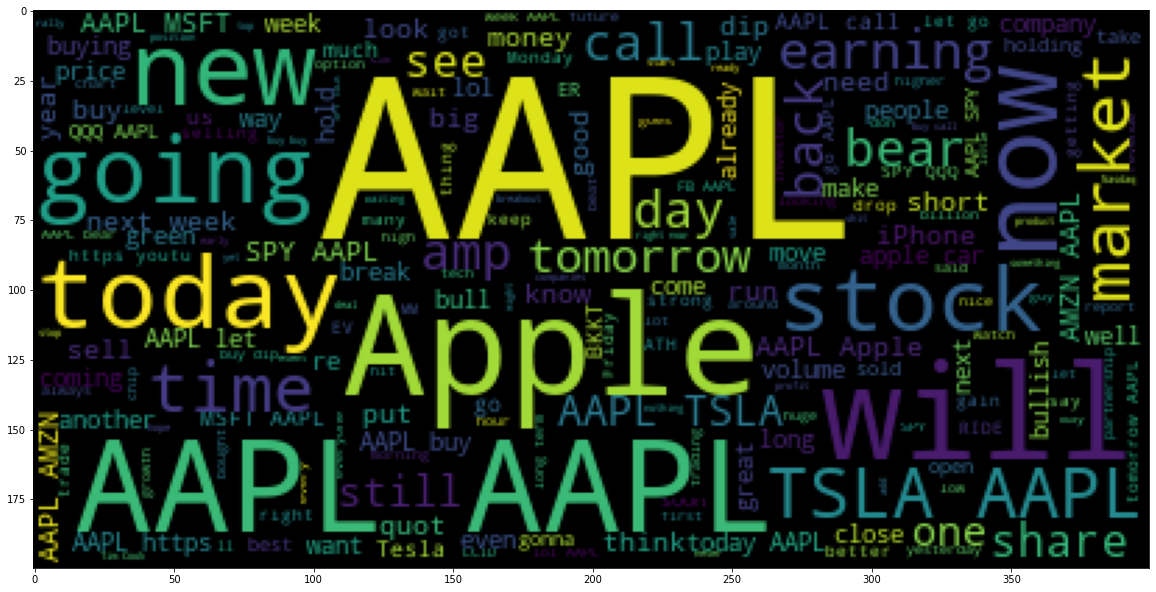

In [ ]:
#negative WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_negative))

## Data Preprocessing 
I delete all tweets where no sentiment was labeled (equal to basic sentiment = 0).
I further delete all columns except for body (which contains the tweet) and basic sentiment which corresponds to the label.

In [ ]:
# save the dataset before modifying
df_labeled = tweets_df
df_labeled.head(2)

,id,created_at,username,name,user_id,body,basic_sentiment,symbol0,symbol1,symbol2,symbol3,symbol4,length
0,410821194,2021-11-28 12:28:21+00:00,chuckygorman,Chuck Gorman,1068147,$AAPL $BA $DIS,0,AAPL,BA,DIS,NaN,NaN,14
1,410821004,2021-11-28 12:25:13+00:00,Renohawk,jessie livermore,162218,$SPY $TSLA $MRNA $AAPL $NVDA \n\nMy thoughts o...,0,AAPL,MRNA,NVDA,SPY,TSLA,1019


In [ ]:
# remove all unlabeled tweets (sentiment = 0) and all columns expect body and basic sentiment
df_labeled = tweets_df[tweets_df['basic_sentiment'] != 0]
df_labeled  = df_labeled[["body","basic_sentiment"]]
print('before:',df_labeled.head(2))

#change positive sentiment to class 0 and negative sentiment to class 1
df_labeled['basic_sentiment'] = df_labeled['basic_sentiment'].replace((-1,1),(1,0))
print('after:',df_labeled.head(2))

before:                                                 body  basic_sentiment
4  $AAPL $BA $DIS On the new Covid variant -\n\n&...                1
5  Excellent, welcome to crash Monday and beyond ...               -1
after:                                                 body  basic_sentiment
4  $AAPL $BA $DIS On the new Covid variant -\n\n&...                0
5  Excellent, welcome to crash Monday and beyond ...                1


Calculate class weight to account for the imbalance 

In [ ]:
pos, neg= np.bincount(df_labeled['basic_sentiment'])
total = pos+neg
print('positive sentiment (class 0):', pos,'\n negatives sentiment (class 1):',neg, '({:.2f}% of total)\n'.format(
     100 * neg / total))


positive sentiment (class 0): 18206 
 negatives sentiment (class 1): 4694 (20.50% of total)



In [ ]:
weight_for_0 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / neg) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (positives sentiment): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (negatives sentiment): {:.2f}'.format(weight_for_1))


Weight for class 0 (positives sentiment): 0.63
Weight for class 1 (negatives sentiment): 2.44


In [ ]:
# create huggingface/ arrow dataset from pandas df
dataset = Dataset.from_pandas(df_labeled).remove_columns("__index_level_0__")
dataset[0]

{'basic_sentiment': 0,
 'body': '$AAPL $BA $DIS On the new Covid variant -\n\n&quot;It presents mild disease with symptoms being sore muscles and tiredness for a day or two not feeling well,&quot; Coetzee explained. &quot;So far, we have detected that those infected do not suffer the loss of taste or smell. They might have a slight cough. There are no prominent symptoms. Of those infected some are currently being treated at home.&quot;'}

In [ ]:
print("before: ",dataset.features)
# add labels to sentiment scores for better readability
feat_sentiment = ClassLabel(num_classes = 2,names=["negative", "positive"])
dataset = dataset.cast_column("basic_sentiment", feat_sentiment)
print("after: ", dataset.features)

before:  {'body': Value(dtype='string', id=None), 'basic_sentiment': Value(dtype='int64', id=None)}


Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

after:  {'body': Value(dtype='string', id=None), 'basic_sentiment': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}


In [ ]:
#Split into training and test data
dataset_split = dataset.train_test_split(test_size=0.1) # to apply train_test_split I need to have a dataset not a datasetDict object 
train_data = dataset_split['train']
test_data = dataset_split['test']

#Split training data into training and validation data
train_data_split = train_data.train_test_split(test_size=1/9)
train_data = train_data_split['train']
validation_data = train_data_split['test']

train_test_validation_data = DatasetDict({
    'train': train_data,
    'validation': validation_data,
    'test': test_data
})

print(train_test_validation_data)
train_test_validation_data['train'].features


DatasetDict({
    train: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 18320
    })
    validation: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 2290
    })
})


{'basic_sentiment': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None),
 'body': Value(dtype='string', id=None)}

Check distribution of labels wihtin the random subsamples and calculate the classweights

---



In [ ]:
pos_train, neg_train = np.bincount(train_test_validation_data['train']['basic_sentiment'])
print('positive sentiment (class 0):', pos_train,'\n negatives sentiment (class 1):',neg_train, '({:.2f}% of total)\n'.format(
     100 * neg / total))

positive sentiment (class 0): 14596 
 negatives sentiment (class 1): 3724 (20.50% of total)



In [ ]:
pos_valid, neg_valid = np.bincount(train_test_validation_data['validation']['basic_sentiment'])
print('positive sentiment (class 0):', pos_valid,'\n negatives sentiment (class 1):',neg_valid, '({:.2f}% of total)\n'.format(
     100 * neg / total))


positive sentiment (class 0): 1805 
 negatives sentiment (class 1): 485 (20.50% of total)



Tokenization

In [ ]:
checkpoint ='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(dat):
  return tokenizer(dat["body"], truncation=True)

tokenized_dataset = train_test_validation_data.map(tokenize_function, batched = True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
print(tokenized_dataset)

# the tokenized dataset contains the feature (body), the label(basic_sentiment) and the 
# atten_mask,input_ids and token_type_id


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 18320
    })
    validation: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 2290
    })
})


In [ ]:
#in the following the column body is removed since it is a string and not needed anymore (information is in 'input ids')
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=["attention_mask","input_ids","token_type_ids"],
    label_cols= ["basic_sentiment"],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 32
)
tf_validation_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=["attention_mask","input_ids","token_type_ids"],
    label_cols= ["basic_sentiment"],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 32
)

Model Fine Tuning

In [ ]:
# create model - since this is a bert model, it will use
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Introduce class weights to account for the imbalance of the dataset

In [ ]:
# define loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# epoch, lr scheduler and optimizer
num_epochs = 3
num_train_steps = len(tf_train_dataset)*num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate = 5e-5, end_learning_rate = 0.0,
    decay_steps = num_train_steps)
opt = Adam(learning_rate = lr_scheduler)

#METRICS = [
#      tf.keras.metrics.TruePositives(name='tp'),
#      tf.keras.metrics.FalsePositives(name='fp'),
#      tf.keras.metrics.TrueNegatives(name='tn'),
#      tf.keras.metrics.FalseNegatives(name='fn'), 
#      tf.keras.metrics.AUC(name='auc')     
#]

#metric = tf.keras.metrics.AUC(name='auc') 

model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])
# uses this fit function https://www.tensorflow.org/api_docs/python/tf/keras/Model
weighted_history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    batch_size = 16,
    epochs=1,
    class_weight = class_weight 
)

 30/572 [>.............................] - ETA: 8:13 - loss: 0.7045 - accuracy: 0.5437

ResourceExhaustedError: ignored

In [ ]:
print(output.logits.shape)
print(output.logits)

# turn output into predictions
predictions = tf.math.softmax(output.logits,axis=-1)
print(predictions)
